In [9]:
import cv2
import os
import csv
import random
import pywt
import time
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.stats import kurtosis, skew

In [46]:
PATH = os.path.abspath(os.path.join('.'))
TRAIN_PATHS = os.path.join(PATH, "train")
TEST_PATH = os.path.join(PATH, "test")
SOURCE_IMAGES = []
train_images = []
test_images = []

for src in os.listdir(TRAIN_PATHS):
    folder_path = os.path.join(TRAIN_PATHS, src)
    if os.path.isdir(folder_path):
        SOURCE_IMAGES.append(folder_path)
        train_images = train_images + glob(os.path.join(folder_path, "*.jpg"))
        train_images = train_images + glob(os.path.join(folder_path, "*.JPG"))

test_images = glob(os.path.join(TEST_PATH, "*.tif"))

Path: /home/nando/Projects/ml/assignment2/train/Sony-NEX-7/(Nex7)1.JPG
Path: /home/nando/Projects/ml/assignment2/train/Sony-NEX-7/(Nex7)4.JPG
Path: /home/nando/Projects/ml/assignment2/train/Sony-NEX-7/(Nex7)3.JPG

Path: /home/nando/Projects/ml/assignment2/test/img_0add779_unalt.tif
Path: /home/nando/Projects/ml/assignment2/test/img_0a3162a_unalt.tif
Path: /home/nando/Projects/ml/assignment2/test/img_0abb191_unalt.tif


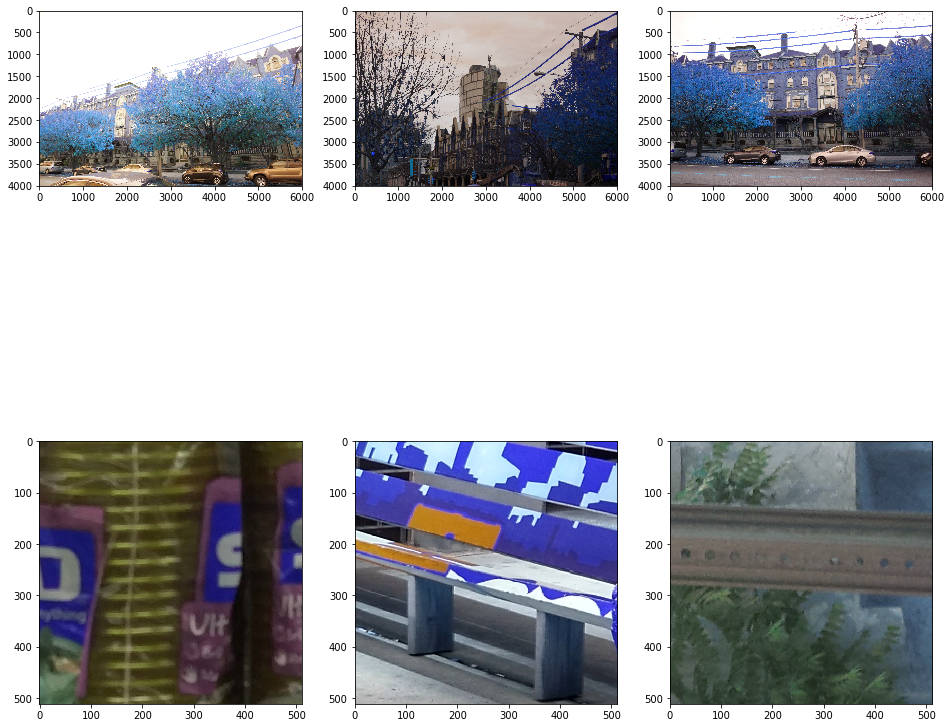

In [45]:
rnd_train_images = random.sample(train_images, 3)
rnd_test_images = random.sample(test_images, 3)

plt.figure(figsize=(16,16))

print('Path: {0}'.format(rnd_train_images[0]))
plt.subplot(231)
plt.imshow(cv2.imread(rnd_train_images[0]))

print('Path: {0}'.format(rnd_train_images[1]))
plt.subplot(232)
plt.imshow(cv2.imread(rnd_train_images[1]))

print('Path: {0}'.format(rnd_train_images[2]))
plt.subplot(233)
plt.imshow(cv2.imread(rnd_train_images[2]));

print('\nPath: {0}'.format(rnd_test_images[0]))
plt.subplot(234)
plt.imshow(cv2.imread(rnd_test_images[0]))

print('Path: {0}'.format(rnd_test_images[1]))
plt.subplot(235)
plt.imshow(cv2.imread(rnd_test_images[1]))

print('Path: {0}'.format(rnd_test_images[2]))
plt.subplot(236)
plt.imshow(cv2.imread(rnd_test_images[2]));

In [47]:
def load_images():
    PATH = os.path.abspath(os.path.join('.'))
    TRAIN_PATHS = os.path.join(PATH, "train")
    TEST_PATH = os.path.join(PATH, "test")
    SOURCE_IMAGES = []
    train_images = []
    test_images = []

    for src in os.listdir(TRAIN_PATHS):
        folder_path = os.path.join(TRAIN_PATHS, src)
        if os.path.isdir(folder_path):
            SOURCE_IMAGES.append(folder_path)
            train_images = train_images + glob(os.path.join(folder_path, "*.jpg"))
            train_images = train_images + glob(os.path.join(folder_path, "*.JPG"))

    test_images = glob(os.path.join(TEST_PATH, "*.tif"))
    
    return train_images, test_images

def crop_image(img_path, crop_size = 512):
    crops = []
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    y = 0
    x = 0

    while y <= h:
        y_crop = y + crop_size
        while x <= w:
            x_crop = x + crop_size

            if (y_crop <= h) and (x_crop <= w):
                cropped = img[y:y_crop, x:x_crop]
            elif (y_crop <= h) and (x_crop > w):
                cropped = img[y:y_crop, -1*crop_size:]
            elif (y_crop > h) and (x_crop <= w):
                cropped = img[-1*crop_size:, x:x_crop]
            else:
                cropped = img[-1*crop_size:, -1*crop_size:]

            crops.append(cropped)
            x = x_crop
        x = 0
        y = y_crop
    return crops

def crop_images(images, crop_size = 512):
    cropped_images = []
    camera_models = []
    for img_path in images:
        crops = crop_image(img_path)
        cropped_images = cropped_images + crops
        
        camera_model = img_path[img_path.find("(")+1:img_path.find(")")]
        for i in range(len(crops)):
            camera_models.append(camera_model)

    return cropped_images, camera_models

def dwt2(image):
    cA, (cH, cV, cD) = pywt.dwt2(image,'haar')
    return cA, cH, cV, cD

def extract_features(image, resize=True):
    _image = image
    if resize:
        _image = cv2.resize(image, (20, 20))
    extracted_features = extract_patches_2d(_image, (2, 2), max_patches=50, random_state=0)
    return extracted_features.flatten().tolist()

def main_train():
    train_images, test_images = load_images()

    with open('train.csv', 'w') as file:
        wr = csv.writer(file, quoting=csv.QUOTE_NONNUMERIC)
        
        features_names = []
        for i in range(1062):
            features_names = features_names + ['f{}'.format(i)]
        features_names = features_names + ['model']
        wr.writerow(features_names)
        
        i = 0
        for img_path in train_images:
            camera_model = img_path[img_path.find("(")+1:img_path.find(")")]
            cropped_images = crop_image(img_path)

            for cropped_image in cropped_images:
                features = []
                hist = cv2.calcHist([img],[0],None,[256],[0,256])
                cA, cH, cV, cD = dwt2(cropped_image)
                features = features + extract_features(cA)
                features = features + extract_features(cH)
                features = features + extract_features(cV)
                features = features + extract_features(cD)
                features = features + hist.flatten().tolist()
                features.append(np.mean(features))
                features.append(np.average(features))
                features.append(np.var(features))
                features.append(np.std(features))
                features.append(np.amax(features))
                features.append(np.amin(features))
                features.append(camera_model)

                wr.writerow(features)
                i += 1

In [49]:
## Extrai features de treino

start_time = time.time()

main_train()

print("Time: {:.2f}s".format(time.time() - start_time))

Time: 622.41s


In [7]:
def main_test():
    train_images, test_images = load_images()

    with open('test.csv', 'w') as file:
        wr = csv.writer(file, quoting=csv.QUOTE_NONNUMERIC)
        for img_path in test_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            features = []
            cA, cH, cV, cD = dwt2(img)
            features = features + extract_features(cA)
            features = features + extract_features(cH)
            features = features + extract_features(cV)
            features = features + extract_features(cD)

            wr.writerow(features)

In [8]:
## Extrai  features de test

start_time = time.time()

main_test()

print("Time: {:.2f}s".format(time.time() - start_time))

Time: 28.81s


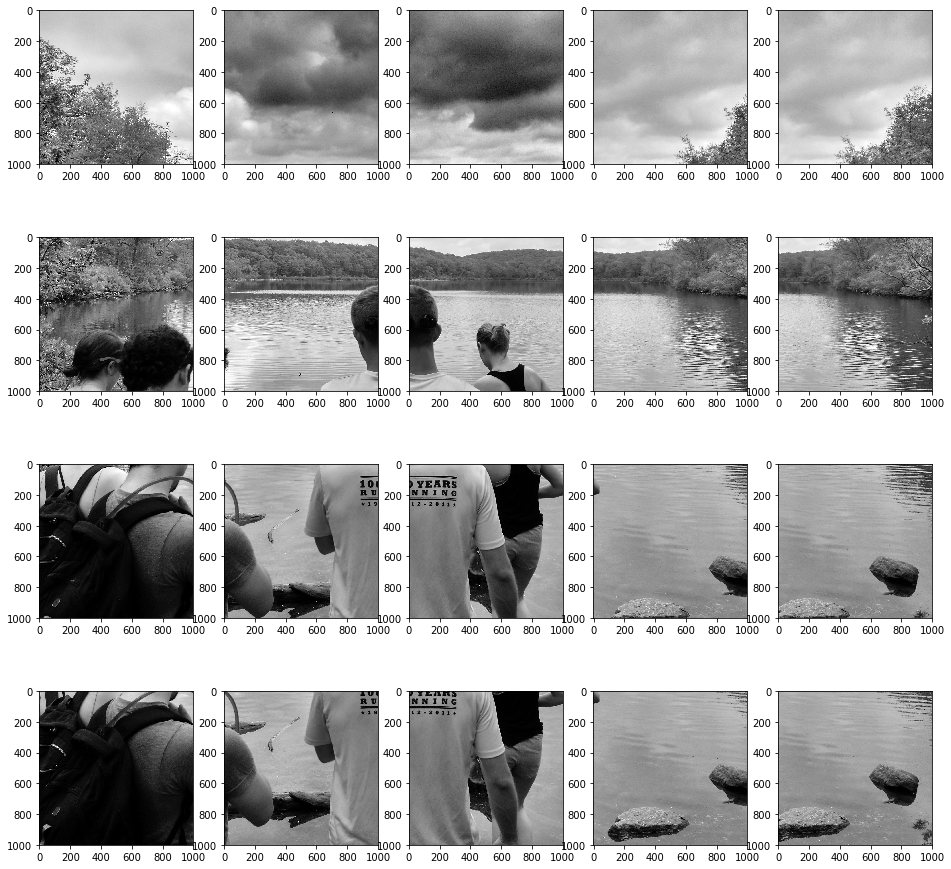

In [5]:
img_path = "/home/nando/Projects/ml/assignment2/train/Motorola-X/(MotoX)1.jpg"
crop_size = 1000
crops = crop_image(img_path, crop_size)

fig = plt.figure(figsize=(16,16))

for idx in range(len(crops)):
    ax = fig.add_subplot(4, 5, idx+1)
    ax.imshow(crops[idx], cmap='gray')

(512, 512)
(256, 256) (256, 256) (256, 256) (256, 256)


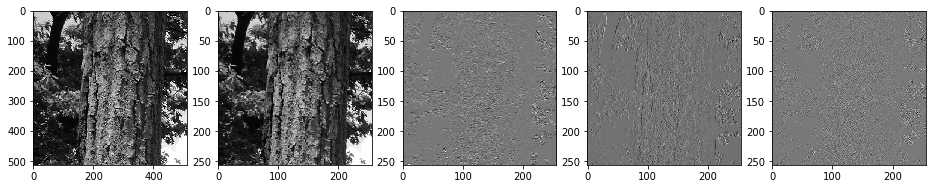

In [22]:
import pywt

cropped_images, camera_models = crop_images(train_images)

#print(pywt.wavelist())
cA, (cH, cV, cD) = pywt.dwt2(cropped_images[0],'haar')
print(cropped_images[0].shape)
print(cA.shape, cH.shape, cV.shape, cD.shape)

plt.figure(figsize=(16,16))
plt.subplot(151)
plt.imshow(cropped_images[0], cmap='gray')
plt.subplot(152)
plt.imshow(cA, cmap='gray')
plt.subplot(153)
plt.imshow(cH, cmap='gray')
plt.subplot(154)
plt.imshow(cV, cmap='gray')
plt.subplot(155)
plt.imshow(cD, cmap='gray')

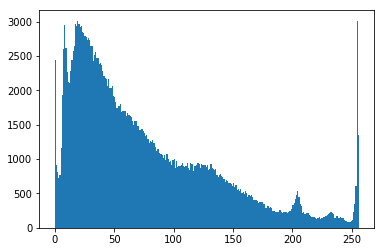

256


In [30]:
img = cropped_images[0]
hist = cv2.calcHist([img],[0],None,[256],[0,256])
plt.hist(img.ravel(),256,[0,256])
plt.show()

print(len(hist.flatten()))